# Assignment 6
1. Use yeast dataset from UCI http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data
2. Remove the first column and use the last column as the target
3. Only leave CYT and VAC classes
4. Replace [0.3, 0.5, 0.7] in feature 2 to null
5. Replace [0.26, 0.36, 0.64] in feature 3 to null
6. Split the data

7. Impute the data (or not, it's your call)
8. Build a outlier detection model to classify VAC from CYT, i.e. 0 from 1
9. Build a classifer using sample augmentation techniques to flassify VAC from CYT, i.e. 0 from 1
10. Try different methods and hyper paramters

11. Report perfromance using F-1 score

In [1]:
! pip install imblearn --user

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from time import time

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from impyute.imputation.cs import mice
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

from numpy import where
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
pd.options.mode.chained_assignment = None  # default='warn' 

In [3]:
#Load the dataset into a pandas dataframe
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data'
yeast_data = pd.read_fwf(url,header= None)
# dtypes for our columns
yeast_data.dtypes

0     object
1    float64
2    float64
3    float64
4    float64
5    float64
6    float64
7    float64
8    float64
9     object
dtype: object

In [4]:
# Descriptive statistics of the DataFrame
yeast_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,1484.0,0.500121,0.137299,0.11,0.41,0.49,0.58,1.00
2,1484.0,0.499933,0.123924,0.13,0.42,0.49,0.57,1.00
3,1484.0,0.500034,0.086670,0.21,0.46,0.51,0.55,1.00
4,1484.0,0.261186,0.137098,0.00,0.17,0.22,0.32,1.00
5,1484.0,0.504717,0.048351,0.50,0.50,0.50,0.50,1.00
6,1484.0,0.007500,0.075683,0.00,0.00,0.00,0.00,0.83
7,1484.0,0.499885,0.057797,0.00,0.48,0.51,0.53,0.73
8,1484.0,0.276199,0.106491,0.00,0.22,0.22,0.30,1.00


In [5]:
#we drop the first column as it is not needed for this problem
yeast_data = yeast_data.iloc[: , 1:]
yeast_data.head()

,1,2,3,4,5,6,7,8,9
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [6]:
yeast_data[9].value_counts(dropna = False)

CYT    463
NUC    429
MIT    244
ME3    163
ME2     51
ME1     44
EXC     35
VAC     30
POX     20
ERL      5
Name: 9, dtype: int64

In [7]:
yeast_data = yeast_data.loc[(yeast_data[9] == "CYT") | (yeast_data[9] == "VAC")]
yeast_data.head()

,1,2,3,4,5,6,7,8,9
5,0.51,0.40,0.56,0.17,0.5,0.5,0.49,0.22,CYT
9,0.40,0.39,0.60,0.15,0.5,0.0,0.58,0.30,CYT
12,0.40,0.42,0.57,0.35,0.5,0.0,0.53,0.25,CYT
15,0.46,0.44,0.52,0.11,0.5,0.0,0.50,0.22,CYT
16,0.47,0.39,0.50,0.11,0.5,0.0,0.49,0.40,CYT


In [8]:
yeast_data[2].replace({0.3:np.NaN, 0.5:np.NaN, 0.7:np.NaN}, inplace=True)
yeast_data[3].replace({0.26:np.NaN, 0.36:np.NaN, 0.64:np.NaN}, inplace=True)
#count the NaNs per column
yeast_data.isna().sum()


1     0
2    26
3     5
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64

We decided to classify VAC=1 and CYT=0. This way, we will get F-1 score for pos_label=1, i.e for VAC which is going to be a hard task to optimise, since we do not have many occurences of VAC in our dataset. So, the F-1 scores are going to be low

In [9]:
# all columns but the last
X = yeast_data.iloc[: , :-1]
# the last column of the df 
y = yeast_data.iloc[:,-1:]
y.replace({("CYT"): 0}, inplace=True)
y.replace({("VAC"): 1}, inplace=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.25)

In [10]:
from sklearn.impute import SimpleImputer
# Simple imputation with mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)
X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

#some manipulation of y to skip errors
y_train_array = y_train.to_numpy().ravel()
y_test_array = y_test.to_numpy().ravel()


In [11]:
#Benchmark model with no outlier detection method
pipe = Pipeline([('classifier', SVC())])

param_grid = [
     {'classifier': [SGDClassifier()],
      'classifier__average': [True, False],
      'classifier__l1_ratio': [0.001, 0.01, 0.1, 1],
      'classifier__alpha': [0.001, 0.01, 0.1, 1]},
    
     {'classifier': [SVC()],
      'classifier__gamma':[0.001, 0.01, 0.1, 1],
      'classifier__C': [100,1000,1250,1500]},
    
     {'classifier': [LogisticRegression()], 
      'classifier__C': [0.001, 0.01, 0.1, 1]}]

grid_search = GridSearchCV(pipe, param_grid, cv = StratifiedKFold(), scoring='f1')
start = time()
grid_search.fit(X_train_imp, y_train_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))


Model training took 1.24 seconds
Best cross-validation score: 0.41
Test set score: 0.00
Best parameters: {'classifier': SVC(C=1000, gamma=1), 'classifier__C': 1000, 'classifier__gamma': 1}



In [12]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
methods = [DBSCAN(eps = 0.10, min_samples = 20), 
           IsolationForest(n_estimators=100, contamination=.05), 
           LocalOutlierFactor(n_neighbors=20, contamination=.50), 
           EllipticEnvelope(contamination=.05), 
           OneClassSVM(kernel="rbf", gamma=1, nu=0.03)]
for outliers in methods:
    # Build an outlier detection model to classify VAC from CYT
     
    pred = outliers.fit_predict(X_train_imp)
    # the negatives are the outliers.
    exists = 0 in pred
    if exists == True:
        filter_ = 0 
    else:
        filter_ = 1
    anom_index = where(pred == filter_)
    X_train_out = X_train_imp[anom_index]
    y_train_out= y_train_array[anom_index]
    count_arr = np.bincount(y_train_out)
    print(outliers)
    # Count occurrence of element '3' in numpy array
    print('Total occurences of "0" in y: ', count_arr[0])
    # Count occurrence of element '5' in numpy array
    print('Total occurences of "1" in y: ', count_arr[1])
    grid_search = GridSearchCV(pipe, param_grid, cv = StratifiedKFold(), scoring='f1')

    start = time()
    grid_search.fit(X_train_out, y_train_out)
    
    print("Model training took %.2f seconds"
        % ((time() - start)))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
    print("Best parameters: {}\n".format(grid_search.best_params_))

DBSCAN(eps=0.1, min_samples=20)
Total occurences of "0" in y:  145
Total occurences of "1" in y:  10
Model training took 0.88 seconds
Best cross-validation score: 0.00
Test set score: 0.00
Best parameters: {'classifier': SGDClassifier(alpha=0.001, average=True, l1_ratio=0.001), 'classifier__alpha': 0.001, 'classifier__average': True, 'classifier__l1_ratio': 0.001}

IsolationForest(contamination=0.05)
Total occurences of "0" in y:  327
Total occurences of "1" in y:  23
Model training took 1.14 seconds
Best cross-validation score: 0.37
Test set score: 0.00
Best parameters: {'classifier': SVC(C=1000, gamma=1), 'classifier__C': 1000, 'classifier__gamma': 1}

LocalOutlierFactor(contamination=0.5)
Total occurences of "0" in y:  176
Total occurences of "1" in y:  9
Model training took 0.94 seconds
Best cross-validation score: 0.00
Test set score: 0.00
Best parameters: {'classifier': SGDClassifier(alpha=0.001, average=True, l1_ratio=0.001), 'classifier__alpha': 0.001, 'classifier__average': Tr

In [13]:
outliers= OneClassSVM(gamma=1, nu=0.03)
pred = outliers.fit_predict(X_train_imp)
anom_index = where(pred == 1)
X_train_out = X_train_imp[anom_index]
y_train_out= y_train_array[anom_index]
# optimal model
model = SVC(C=1000, gamma=1)
# train model
model.fit(X_train_out, y_train_out)
# test score
y_predicted = model.predict(X_test_imp)
score = f1_score(y_test, y_predicted)
print("F-1 Test Score: {0:.3f}".format(score))

F-1 Test Score: 0.000


In [14]:
count_arr = np.bincount(y_predicted)

# Count occurrence of element '3' in numpy array
print('Total occurences of "0" in y_predicted: ', count_arr[0])
# Count occurrence of element '5' in numpy array
print('Total occurences of "1" in y_predicted: ', count_arr[1])

Total occurences of "0" in y_predicted:  123
Total occurences of "1" in y_predicted:  1


In [15]:
color = ['blue','orange']

target_count = y_train.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

Class 0: 344
Class 1: 25
Proportion: 13.76 : 1


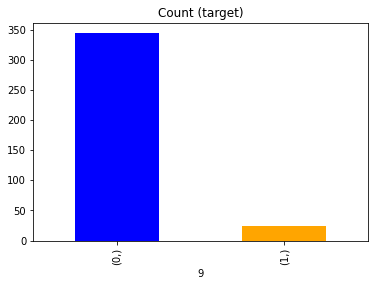

In [16]:
color = ['blue','orange']

target_count = y_train.value_counts()
target_count.plot(kind='bar', title='Count (target)', color = color);

In [17]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train_imp, y_train)

print(X_ros.shape[0] - X_train_imp.shape[0], 'new random picked points')


319 new random picked points


Random over-sampling:
9  
0.0    344
1.0    344
dtype: int64


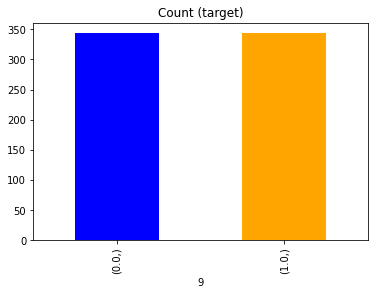

In [18]:
# Class count
count_class_0, count_class_1 = y_ros.value_counts()

# Divide by class
df_class_0 = y_ros[y_ros == 0]
df_class_1 = y_ros[y_ros == 1]

df_test_over = pd.concat([df_class_0, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.value_counts())

df_test_over.value_counts().plot(kind='bar', title='Count (target)',color = color);


In [19]:
# Convert to numpy
y_ros_array = y_ros.to_numpy().ravel()

start = time()
grid_search.fit(X_ros, y_ros_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))

Model training took 3.24 seconds
Best cross-validation score: 0.79
Test set score: 0.09
Best parameters: {'classifier': SVC(C=1500, gamma=1), 'classifier__C': 1500, 'classifier__gamma': 1}



In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train_imp, y_train)
# Convert to numpy
y_sm_array = y_ros.to_numpy().ravel() 
# Divide by class
df_class_0 = y_sm[y_sm == 0]
df_class_1 = y_sm[y_sm == 1]

df_test_over = pd.concat([df_class_0, df_class_1], axis=0)

print('Random over-sampling:')
print(df_test_over.value_counts())

Random over-sampling:
9  
0.0    344
1.0    344
dtype: int64


In [21]:
start = time()
grid_search.fit(X_sm, y_sm_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))

Model training took 2.56 seconds
Best cross-validation score: 0.82
Test set score: 0.05
Best parameters: {'classifier': SVC(C=1500, gamma=1), 'classifier__C': 1500, 'classifier__gamma': 1}



In [22]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_resample(X_train_imp, y_train)
# Convert to numpy array
y_smt_array = y_smt.to_numpy().ravel() 

start = time()
grid_search.fit(X_smt, y_smt_array)
   
print("Model training took %.2f seconds"
    % ((time() - start)))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test_imp, y_test)))
print("Best parameters: {}\n".format(grid_search.best_params_))

Model training took 2.50 seconds
Best cross-validation score: 0.85
Test set score: 0.05
Best parameters: {'classifier': SVC(C=1500, gamma=1), 'classifier__C': 1500, 'classifier__gamma': 1}



In [23]:
! git commit -am "test" 
 


In [24]:
! git push